# Dataset Pipeline testing

In [ ]:
import datetime
import enum
import xml.etree.ElementTree as ET
from dataclasses import dataclass
from functools import wraps
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go


import plotly.express as px
import imageio.v3 as iio
import glob
import matplotlib.pyplot as plt
# import bioformats as bf
# import javabridge
import numpy as np
import pandas as pd
import h5py
import re
import scipy.fft as fft

import pathlib
import platform
plt2 = platform.system()
if plt2 == 'Windows': pathlib.PosixPath = pathlib.WindowsPath

# import frame_gen as fg

# Fourier

In [3]:
results = pd.read_hdf(Path("data/Analysis_data/2020-02-05_15.41.32-NAs-T1354-GFP_Burst.h5"), mode="r", key="fourier")

In [4]:
last_frame = np.sort(results['frame'].unique())[-1]
last_frame

999

In [5]:
valid_granule_fourier = results[(results['valid'] == True) & (results['frame'] == 0)]['granule_id']
valid_granule_ids = valid_granule_fourier.unique()
valid_granule_ids

array([ 4,  5,  7, 13, 18, 20, 25, 31, 34, 35], dtype=int64)

In [6]:
granule_fourier = results[(results['granule_id'] == 18) & (results['frame'] == 0)]
magnitude = granule_fourier['magnitude']
order = granule_fourier['order'].tolist()
granule_fourier[:2]
# magnitude[:2]

,im_path,frame,granule_id,order,magnitude,x,y,bbox_left,bbox_bottom,bbox_right,bbox_top,mean_radius,valid,major_axis,minor_axis,eccentricity,mean_intensity
1044,..\2020-02-05_15.41.32-NAs-T1354-GFP_Burst.ims,0,18,2,0.059064-0.014455j,566.924923,645.523954,554,634,581,658,0.745074,True,1.690929,1.315757,0.628107,52615.633721
1045,..\2020-02-05_15.41.32-NAs-T1354-GFP_Burst.ims,0,18,3,-0.005835+0.001059j,566.924923,645.523954,554,634,581,658,0.745074,True,1.690929,1.315757,0.628107,52615.633721


In [7]:
bbox_left = granule_fourier['bbox_left'].iloc[0]
bbox_right = granule_fourier['bbox_right'].iloc[0]
bbox_top = granule_fourier['bbox_top'].iloc[0]
bbox_bottom = granule_fourier['bbox_bottom'].iloc[0]

mean_radius = granule_fourier['mean_radius'].iloc[0]
x_pos = granule_fourier['x'].iloc[0]
y_pos = granule_fourier['y'].iloc[0]
x_pos_relative = x_pos - bbox_left
y_pos_relative = y_pos - bbox_bottom

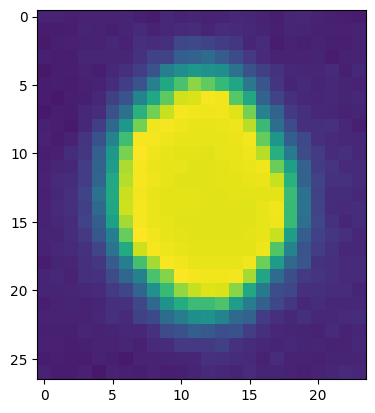

In [18]:
im = iio.imread('data/raw_granule_image_filter.png')
# fig = plt.imshow(im)
fig = plt.imshow(im[bbox_left:bbox_right, bbox_bottom:bbox_top])
# fig.show()
# iio.imwrite("granule_cutout.png", im[bbox_left:bbox_right, bbox_bottom:bbox_top])

In [9]:
scale = 9.941747573

def get_coords(granule_fourier2: pd.DataFrame):
    """Calculates the exact border coordinates for the given granule in an image

    Args:
        granule_fourier2 (pd.DataFrame): Granule in datarame

    Returns:
        Two lists, xs and ys, containing coords
    """
    magnitude2 = granule_fourier2['magnitude']
    # Used for getting relative coords for plotting granules in their correct positions in an image
    # bbox_left2 = granule_fourier2['bbox_left'].iloc[0]
    # bbox_right2 = granule_fourier2['bbox_right'].iloc[0]
    # bbox_top2 = granule_fourier2['bbox_top'].iloc[0]
    # bbox_bottom2 = granule_fourier2['bbox_bottom'].iloc[0]

    mean_radius2 = granule_fourier2['mean_radius'].iloc[0]
    x_pos2 = granule_fourier2['x'].iloc[0]
    y_pos2 = granule_fourier2['y'].iloc[0]
    
    # Used for getting relative coords for plotting granules in their correct positions in an image
    # x_pos_relative2 = x_pos2 - bbox_left2
    # y_pos_relative2 = y_pos2 - bbox_bottom2

    angles2 = np.linspace(0,2*np.pi,400) # sample 400 angles, as in boundary_extraction.py
    magnitudes_2 = np.append( np.array([0.0+0.0j, 0.0+0.0j]), magnitude2) * 400
    radii_12 = mean_radius2 + np.fft.irfft(magnitudes_2, 400)

    # Float coords for boundry
    ys = scale*radii_12*np.cos(angles2)+x_pos2
    xs = scale*radii_12*np.sin(angles2)+y_pos2
    return xs, ys

[ 0.        +0.j          0.        +0.j         23.6255213 -5.78212834j
 -2.33399192+0.42379214j  6.409396  +0.44452742j]


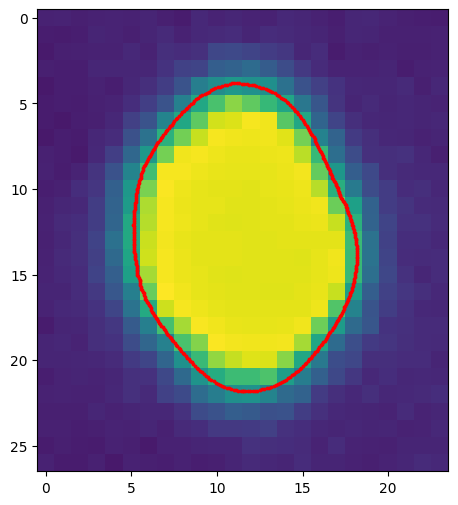

In [10]:
plt.figure(figsize=(6, 6))
# radii = fft.irfft(magnitude) # Radii
# circle = np.linspace(0, 2*np.pi, 114)
angles = np.linspace(0,2*np.pi,400) # sample 400 angles, as in boundary_extraction.py
magnitudes_ = np.append( np.array([0.0+0.0j, 0.0+0.0j]), magnitude) * 400
print(magnitudes_[:5])

# We have add the mean_radius back in, becasue we dropped the first fourier mode 
# We want 400 samples because that was the original length of radii 
radii_1 = mean_radius + np.fft.irfft(magnitudes_, 400)

# plt.scatter(radii*np.cos(circle), radii*np.sin(circle))
plt.imshow(im[bbox_left:bbox_right, bbox_bottom:bbox_top])
# fig.add_trace(go.Scatter(y=9*radii_1*np.cos(angles)+x_pos, x=9*radii_1*np.sin(angles)+y_pos, marker=dict(color='red', size=16)))
# xs,ys = get_coords(granule_fourier)
# plt.scatter(y=xs + x_pos_relative, x=ys + y_pos_relative, c='r',s=3)
plt.scatter(y=scale*radii_1*np.cos(angles) + x_pos_relative, x=scale*radii_1*np.sin(angles) + y_pos_relative, c='r',s=3)
# plt.scatter(y=radii_2*np.cos(angles),x=radii_2*np.sin(angles), c='g')
# plt.title('Reconstructed Signal as a Circle')
# plt.xlabel('Real Part')
# plt.ylabel('Imaginary Part')
# plt.grid(True)
# plt.axis('equal')  # Set equal scaling for both axes
plt.axis('off')
plt.savefig("granule_closeup_with_border.png", transparent=True)
plt.axis('on')
plt.show()

In [11]:
im2 = iio.imread('data/raw_granule_image_filter.png')
fig2 = px.imshow(im2)

# Add Valid granule borders
for id in valid_granule_ids:
    granule_fourier2 = results[(results['granule_id'] == id) & (results['frame'] == 0)]
    xs,ys = get_coords(granule_fourier2)
    # xs = np.round(xs[::4] / 1024,4)    
    xs = np.round(xs,4)    
    ys = np.round(ys,4)    

    fig2.add_trace(go.Scatter(x=xs[::4], y=ys[::4], marker=dict(color='red', size=16), name=f"100 p border {id}"))
    fig2.add_trace(go.Scatter(x=xs, y=ys, marker=dict(color='cyan', size=16), name=f"True Border {id}"))


# Add granule centres (Valid & not valid)
granule_fourier_all = results[(results['frame'] == 0)]['granule_id']
all_graunles = granule_fourier_all.unique()
for granule in all_graunles:
    gran = results[(results['frame'] == 0) & (results['granule_id'] == granule)]
    x2 = gran['x'].iloc[0]
    y2 = gran['y'].iloc[0]
    fig2.add_trace(go.Scatter(y=[x2],x=[y2], marker=dict(color='magenta', size=4), name=f"Granule {granule}"))
fig2.show()

# Grab intersected pixels - Use either pixels or a subset of the True border values (100/400)

In [12]:
im2 = iio.imread('data/raw_granule_image_filter.png')
fig2 = px.imshow(im2)

# Add Valid granule borders
for id in valid_granule_ids:
    granule_fourier2 = results[(results['granule_id'] == id) & (results['frame'] == 0)]
    
    xs, ys = get_coords(granule_fourier2)
    # Pixel coords
    ys_coords = np.round(ys, 0)
    xs_coords = np.round(xs, 0)

    fig2.add_trace(go.Scatter(y=ys[::4], x=xs[::4], marker=dict(color='red', size=16), name=f"True Border - Granule {id}"))
    # print(len(ys[::4]))

    fig2.add_trace(go.Scatter(y=ys_coords, x=xs_coords, marker=dict(color='cyan', size=8), name=f"Pixel Border - Granule {id}"))

# fig2.add_trace(go.Scatter(y=y_cirle, x=x_cirle, marker=dict(color='green', size=8), name=f"Pixel Border - Granule {id}"))


fig2.show()

# YOLOv8 segmentation dataset format

https://docs.ultralytics.com/datasets/segment/#ultralytics-yolo-format

Currently the segementation mask consists of all 400 points. Depending on model performance and limitations, consider reducing this.
Testing shows 100 points is enough to get decent accuracy?

In [13]:
granule_fourier2 = results[(results['granule_id'] == id) & (results['frame'] == 0)]
print(str(granule_fourier2.iloc[0]['im_path'].stem) + "_Frame_0")
print('2020-02-05_15.41.32--NAs--T1354-GFP_Burst_Frame_0')

2020-02-05_15.41.32-NAs-T1354-GFP_Burst_Frame_0
2020-02-05_15.41.32--NAs--T1354-GFP_Burst_Frame_0


In [14]:
def create_txt_for_granule():
    
    for frame_id in range(last_frame+1): # For every frame
        valid_granule_fourier = results[(results['valid'] == True) & (results['frame'] == frame_id)]['granule_id']
        valid_granule_ids = valid_granule_fourier.unique()

        yolov8_granule_string = []
        
        assert len(valid_granule_ids) != 0, "No valid granules in frame " + str(frame_id)
        for valid_granule_id in valid_granule_ids: # For every valid granule
            
            granule_fourier = results[(results['granule_id'] == valid_granule_id) & (results['frame'] == frame_id)] # Valid granule fourier terms
            if granule_fourier.empty:
                print(len(valid_granule_ids))
                print(valid_granule_ids)
                print(granule_fourier)

            xs, ys = get_coords(granule_fourier) # 
            # Pixel coords
            xs_pixel_coords = np.round(xs, 0) / 1024
            ys_pixel_coords = np.round(ys, 0) / 1024
            # Create string, x0,y0,x1,y1,...,xn,yn 
            # This is the YOLOv8 segmentation mask format
            zipped_normalized = list(zip(np.round(xs[::4] / 1024,4), np.round(ys[::4] / 1024, 4)))
            coord_string = ''.join(map(lambda xy: str(xy[0]) + " " + str(xy[1]) + " ", zipped_normalized))
            yolov8_granule_string.append("0 " + coord_string + "\n") # 0 is the id of the class belonging to the mask created by the coords_string.

        filename = str(granule_fourier.iloc[0]['im_path'].stem) + f"_Frame_{frame_id}.txt"
        with open("datasets/train_masks/" + filename, "w+") as f:
            f.write(''.join(yolov8_granule_string))
            f.close()

# create_txt_for_granule()
    

2020-02-05_15.41.32-NAs-T1354-GFP_Burst_Frame_0
2020-02-05_15.41.32-NAs-T1354-GFP_Burst_Frame_0

2020-02-05_15.41.32-NAs-T1354-GFP_Burst_Frame_999
2020-02-05_15.41.32-NAs-T1354-GFP_Burst_Frame_999

# Rename all .png's in training folder

In [15]:
import os

def rename_png_files(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Iterate through the files
    for file in files:
        # Check if the file has a .png extension
        if file.endswith(".png"):
            # Construct the new file name (you can modify this part as needed)
            new_name = file.replace('--', '-')

            # Construct the full paths for the old and new names
            old_path = os.path.join(folder_path, file)
            new_path = os.path.join(folder_path, new_name)

            # Rename the file
            os.rename(old_path, new_path)
            print(f'Renamed: {old_path} -> {new_path}')

# Specify the folder path where your PNG files are located
folder_path = "C:/Users/Endre/Desktop/SKOLE/Master/Pipeline/datasets/train"

# Call the function to rename the PNG files in the specified folder
# rename_png_files(folder_path)


# Split dataset into train and val

In [7]:
img_files = list(range(100))
img_files_train = []
img_files_val = []
for i in range(len(img_files)):
    if i % 10 == 0:
        img_files_train.append(img_files[i])
    else:
        img_files_val.append(img_files[i])

print(img_files_train)
print(img_files_val)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [16]:
import os
import shutil

def rename_png_files(img_path, label_path, img_val_path, label_val_path):
    # Get a list of all files in the folder
    img_files = os.listdir(img_path)
    label_files = os.listdir(label_path)

    # 1000 frames, grap 100
    img_files = img_files[::10]
    label_files = label_files[::10]

    # Move images
    for file in img_files:

        # Construct the full paths for the old and new names
        old_path = os.path.join(img_path, file)
        new_path = os.path.join(img_val_path, file)

        # Rename the file
        shutil.move(old_path, new_path)
        print(f'Moved: {old_path} -> {new_path}')

    # Move Labels/Masks
    for file in label_files:

        # Construct the full paths for the old and new names
        old_path = os.path.join(label_path, file)
        new_path = os.path.join(label_val_path, file)

        # Rename the file
        shutil.move(old_path, new_path)
        print(f'Moved: {old_path} -> {new_path}')

# Training data
img_train_path = "C:/Users/Endre/Desktop/SKOLE/Master/Pipeline/datasets/train"
label_train_path = "C:/Users/Endre/Desktop/SKOLE/Master/Pipeline/datasets/train_masks"

# Where to put val data
img_val_path = "C:/Users/Endre/Desktop/SKOLE/Master/Pipeline/datasets/val/images"
label_val_path = "C:/Users/Endre/Desktop/SKOLE/Master/Pipeline/datasets/val/labels"

# Call the function to rename the PNG files in the specified folder
# rename_png_files(img_train_path, label_train_path, img_val_path, label_val_path)


# ------------------------------------------------------------------------------------------------

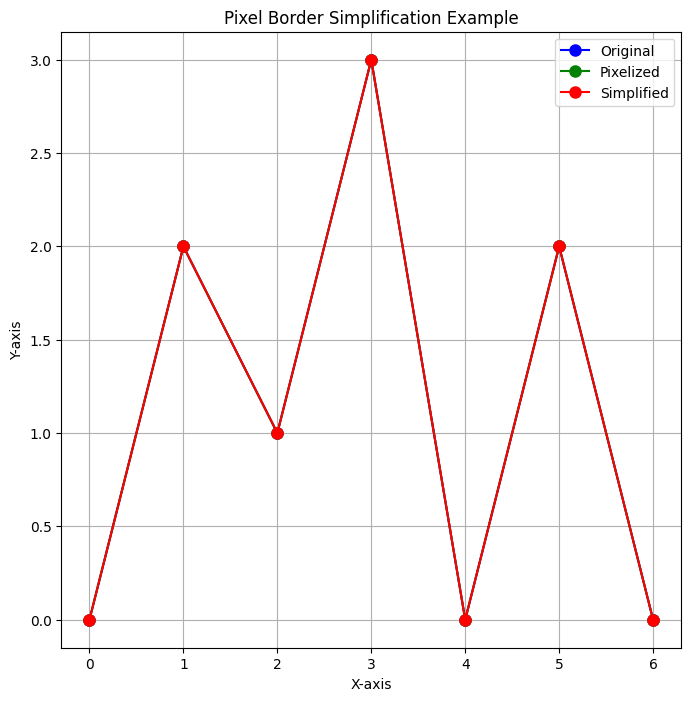

In [17]:
import matplotlib.pyplot as plt

def pixelize(points, pixel_size):
    pixelized_points = []
    for x, y in points:
        pixelized_points.append((round(x / pixel_size), round(y / pixel_size)))
    return pixelized_points

def rdp_simplify(points, tolerance):
    if len(points) < 3:
        return points

    first_point, last_point = points[0], points[-1]
    max_distance = 0
    max_index = 0

    for i in range(1, len(points) - 1):
        distance = perpendicular_distance(points[i], first_point, last_point)
        if distance > max_distance:
            max_distance = distance
            max_index = i

    if max_distance > tolerance:
        left_part = rdp_simplify(points[:max_index + 1], tolerance)
        right_part = rdp_simplify(points[max_index:], tolerance)
        return left_part[:-1] + right_part
    else:
        return [first_point, last_point]

def perpendicular_distance(point, line_start, line_end):
    x0, y0 = line_start
    x1, y1 = line_end
    x, y = point

    num = abs((x1 - x0) * (y0 - y) - (x0 - x) * (y1 - y0))
    den = ((x1 - x0)**2 + (y1 - y0)**2)**0.5

    return num / den

def plot_points(points, color, label):
    x, y = zip(*points)
    plt.plot(x, y, color, label=label, marker='o', linestyle='-', markersize=8)

# Example usage:
original_points = [(0, 0), (1, 2), (2, 1), (3, 3), (4, 0), (5, 2), (6, 0)]
pixel_size = 1  # Assuming one pixel represents one unit
tolerance = 0.5

pixelized_points = pixelize(original_points, pixel_size)
simplified_points = rdp_simplify(pixelized_points, tolerance)

plt.figure(figsize=(8, 8))

# Plot original points
plot_points(original_points, 'b', 'Original')

# Plot pixelized points
plot_points(pixelized_points, 'g', 'Pixelized')

# Plot simplified points
plot_points(simplified_points, 'r', 'Simplified')

plt.title('Pixel Border Simplification Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()
